In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats-2021-task1/BraTS2021_00495.tar
/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar
/kaggle/input/brats-2021-task1/BraTS2021_00621.tar


In [2]:
Train_data_path = '/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar'
!tar -xf /kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar -C /kaggle/working/

In [3]:
!pip install nibabel

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from glob import glob
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

N_CLASSES = 4
BATCH_SIZE = 4
EPOCHS = 3
LR = 1e-3

SLICE_RATIOS_7 = [1/8, 1/4, 3/8, 1/2, 5/8, 3/4, 7/8]


In [5]:
class BraTS2D_7Slices(Dataset):
    def __init__(self, patient_paths):
        self.paths = patient_paths
        self.modalities = ["flair", "t1", "t1ce", "t2"]

    def __len__(self):
        return len(self.paths) * len(SLICE_RATIOS_7)

    def __getitem__(self, idx):
        p_idx = idx // len(SLICE_RATIOS_7)
        s_idx = idx % len(SLICE_RATIOS_7)

        folder = self.paths[p_idx]

        vols = []
        for m in self.modalities:
            files = glob(os.path.join(folder, f"*{m}.nii.gz"))
            if len(files) == 0:
                vol = np.zeros((240, 240, 155), dtype=np.float32)
            else:
                vol = nib.load(files[0]).get_fdata().astype(np.float32)
                vol = (vol - vol.mean()) / (vol.std() + 1e-5)
            vols.append(vol)

        x = np.stack(vols, axis=0)  # (4, H, W, D)

        seg = nib.load(glob(os.path.join(folder, "*seg.nii.gz"))[0]) \
                 .get_fdata().astype(np.int64)

        # 🔴 LIGNE CRITIQUE (IDENTIQUE AU NOTEBOOK DE COMPARAISON)
        seg[seg == 4] = 3

        D = x.shape[-1]
        z = int(SLICE_RATIOS_7[s_idx] * D)

        X = torch.from_numpy(x[..., z])   # (4, H, W)
        Y = torch.from_numpy(seg[..., z]) # (H, W)

        return X, Y


In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

class UNet2D(nn.Module):
    def __init__(self, in_ch=4, out_ch=4):
        super().__init__()
        self.d1 = DoubleConv(in_ch, 32)
        self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(32, 64)
        self.p2 = nn.MaxPool2d(2)

        self.mid = DoubleConv(64, 128)

        self.u2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.c2 = DoubleConv(128, 64)
        self.u1 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.c1 = DoubleConv(64, 32)

        self.out = nn.Conv2d(32, out_ch, 1)

    def forward(self, x):
        c1 = self.d1(x)
        c2 = self.d2(self.p1(c1))
        m  = self.mid(self.p2(c2))

        u2 = self.u2(m)
        c3 = self.c2(torch.cat([u2, c2], 1))
        u1 = self.u1(c3)
        c4 = self.c1(torch.cat([u1, c1], 1))

        return self.out(c4)


In [7]:
def dice_multiclass(logits, target, eps=1e-6):
    pred = logits.argmax(1)
    dices = []

    for c in range(1, N_CLASSES):
        p = (pred == c).float()
        t = (target == c).float()
        inter = (p*t).sum()
        union = p.sum() + t.sum()
        if union > 0:
            dices.append((2*inter+eps)/(union+eps))

    if len(dices)==0:
        return torch.tensor(0.0, device=logits.device)
    return torch.mean(torch.stack(dices))


In [8]:
BASE = "/kaggle/working"

patients = [os.path.join(BASE,p) for p in os.listdir(BASE)
            if os.path.isdir(os.path.join(BASE,p))
            and len(glob(os.path.join(BASE,p,"*seg.nii.gz")))>0]

train_p, temp = train_test_split(patients, test_size=0.3, random_state=42)
val_p, test_p = train_test_split(temp, test_size=0.5, random_state=42)

train_ds = BraTS2D_7Slices(train_p)
val_ds   = BraTS2D_7Slices(val_p)
test_ds  = BraTS2D_7Slices(test_p)

train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, BATCH_SIZE)
test_loader  = DataLoader(test_ds, BATCH_SIZE)

print(len(train_p), len(val_p), len(test_p))


875 188 188


In [9]:
model = UNet2D().to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    model.train()
    for X,Y in train_loader:
        X,Y = X.to(device), Y.to(device)
        opt.zero_grad()
        loss = loss_fn(model(X), Y)
        loss.backward()
        opt.step()

    model.eval()
    dices=[]
    with torch.no_grad():
        for X,Y in val_loader:
            X,Y = X.to(device), Y.to(device)
            dices.append(dice_multiclass(model(X),Y).item())

    print(f"Epoch {epoch+1}/{EPOCHS} | Val Dice: {np.mean(dices):.4f}")


Epoch 1/3 | Val Dice: 0.4065
Epoch 2/3 | Val Dice: 0.4780
Epoch 3/3 | Val Dice: 0.4861


In [10]:
model.eval()
dices=[]
with torch.no_grad():
    for X,Y in test_loader:
        X,Y = X.to(device), Y.to(device)
        dices.append(dice_multiclass(model(X),Y).item())

print("TEST Dice:", np.mean(dices))


TEST Dice: 0.4815935042375459


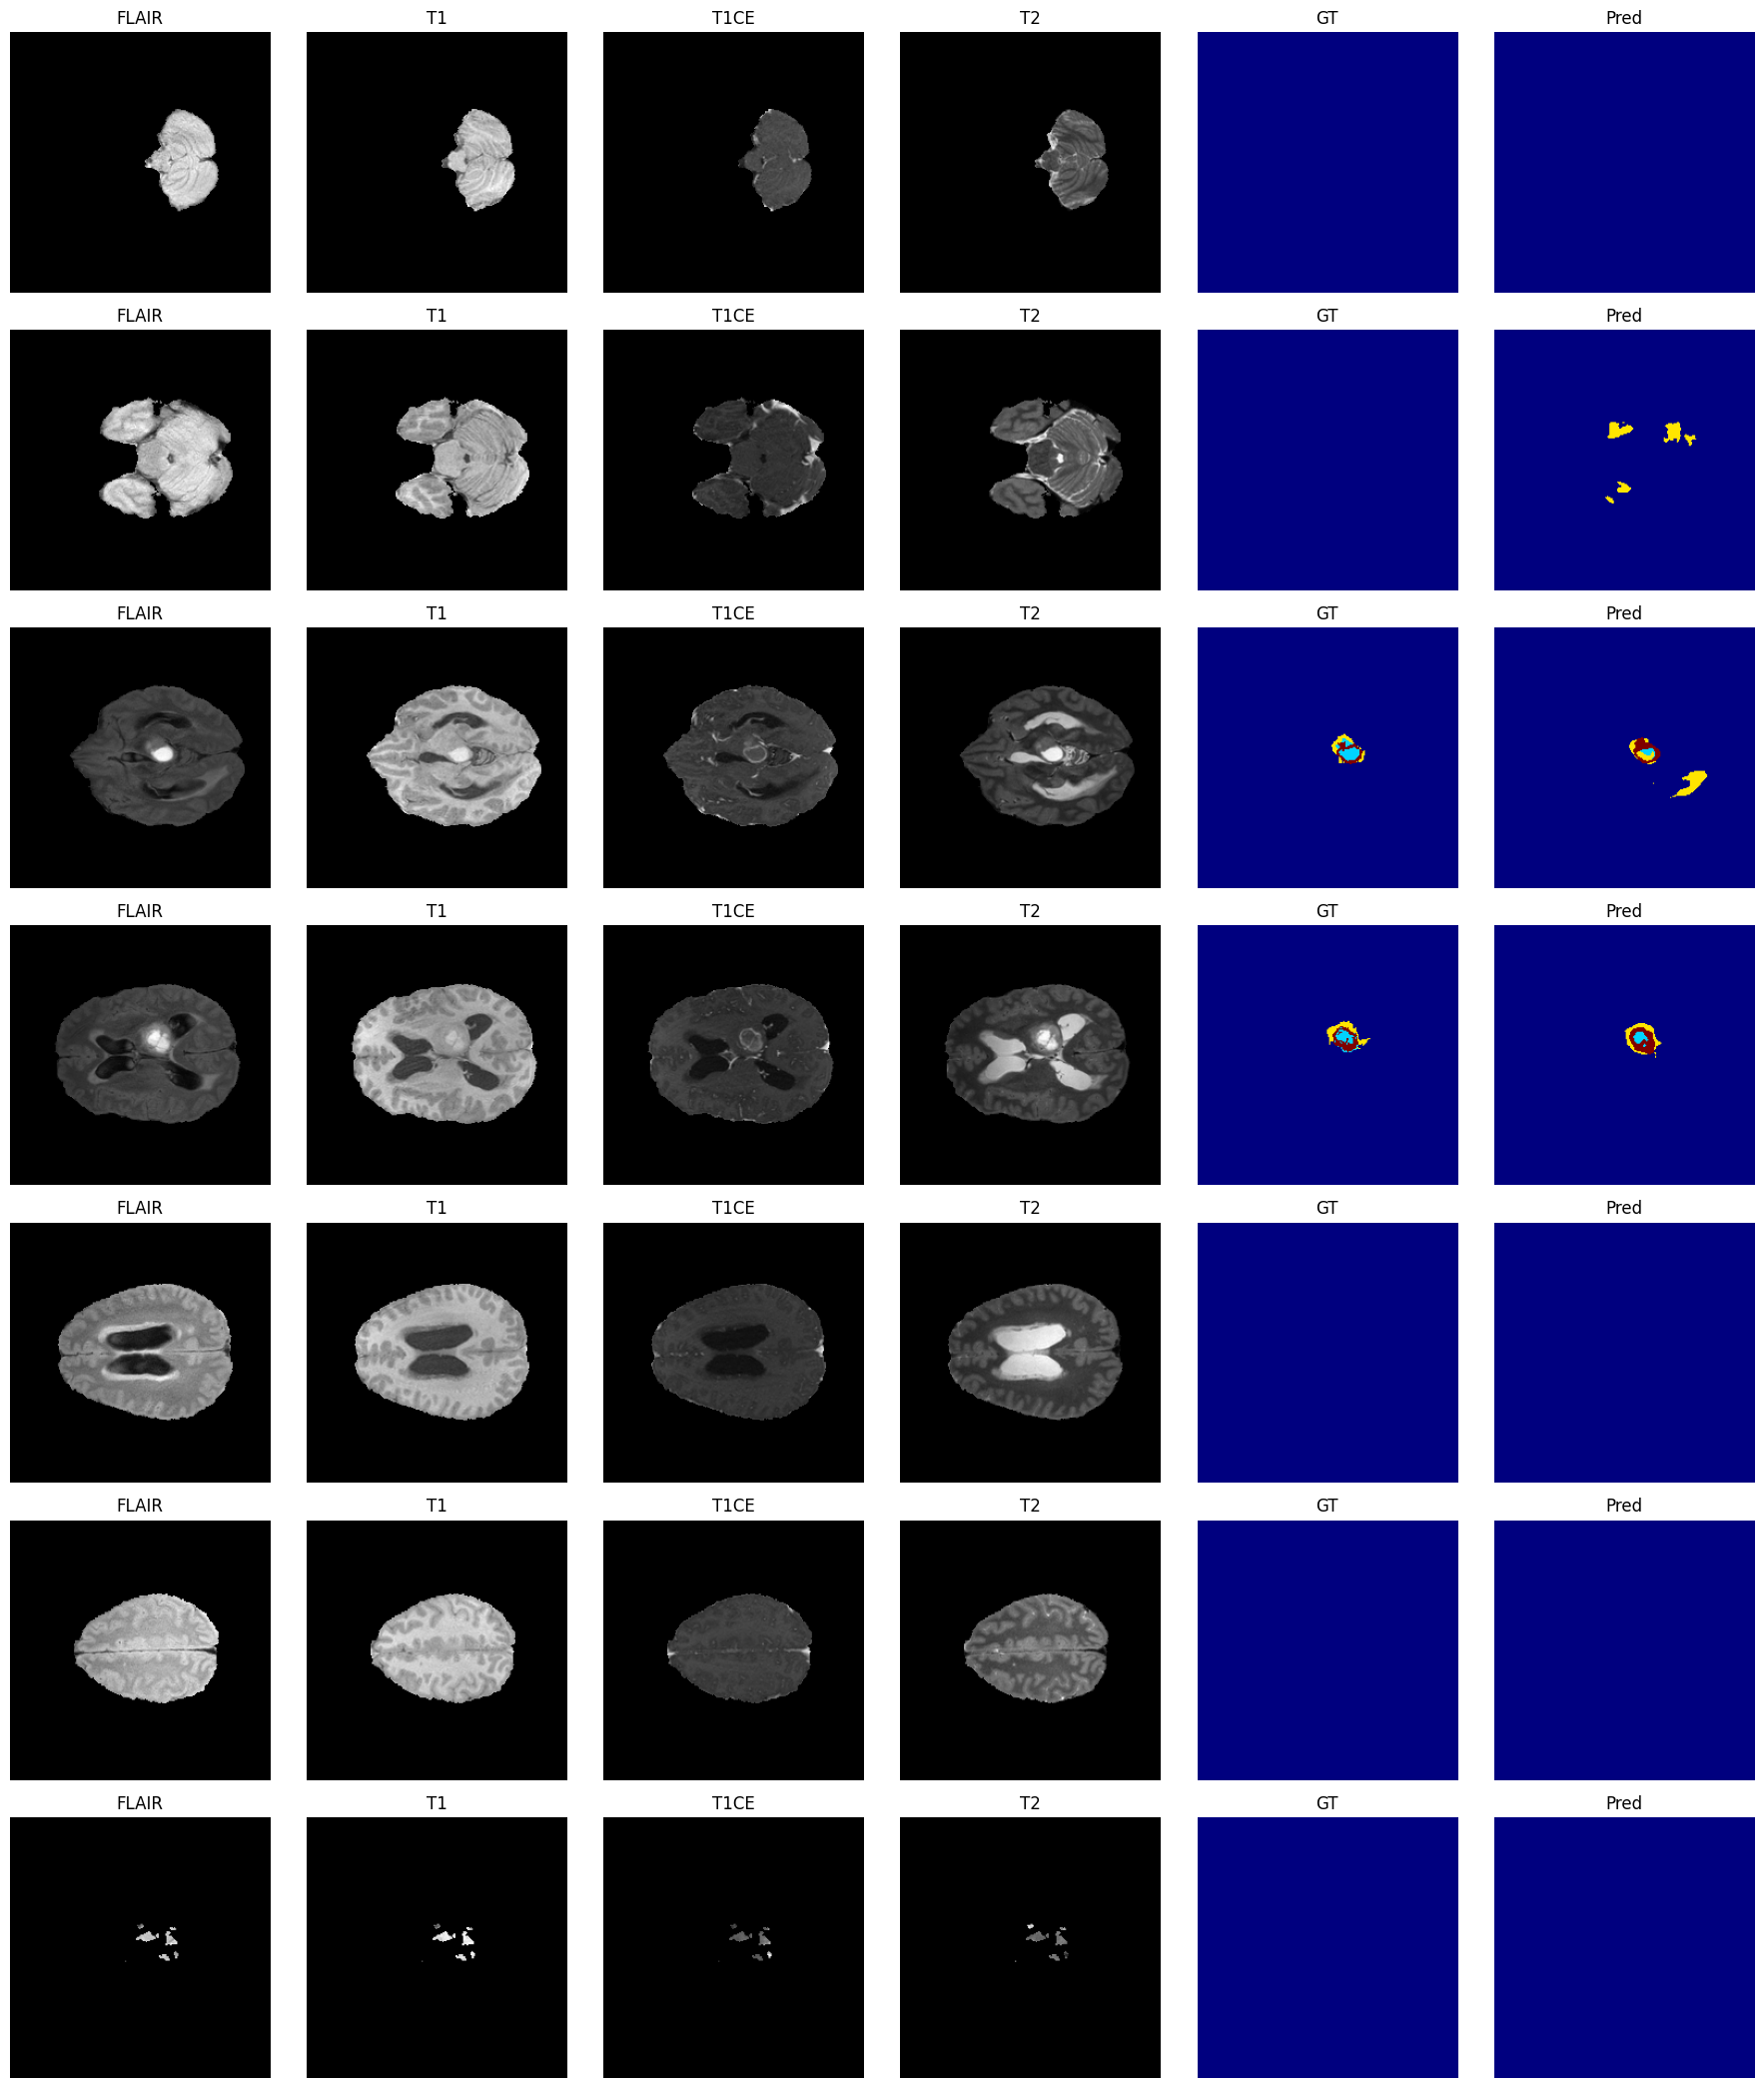

In [11]:
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"

patient_idx = 0                      # patient du test set
base_idx = patient_idx * len(SLICE_RATIOS_7)

fig, axes = plt.subplots(7, 6, figsize=(18, 21))

with torch.no_grad():
    for s in range(7):
        idx = base_idx + s
        X, Y = test_ds[idx]          # <-- ON UTILISE test_ds

        X = X.unsqueeze(0).to(device)
        pred = model(X)
        pred = torch.argmax(pred, dim=1).squeeze().cpu().numpy()

        Y = Y.numpy()

        for m in range(4):
            axes[s, m].imshow(X[0, m].cpu(), cmap="gray")
            axes[s, m].set_title(["FLAIR","T1","T1CE","T2"][m])
            axes[s, m].axis("off")

        axes[s, 4].imshow(Y, cmap="jet", vmin=0, vmax=3)
        axes[s, 4].set_title("GT")
        axes[s, 4].axis("off")

        axes[s, 5].imshow(pred, cmap="jet", vmin=0, vmax=3)
        axes[s, 5].set_title("Pred")
        axes[s, 5].axis("off")

plt.tight_layout()
plt.show()
